In [1]:
import matplotlib.pyplot as plt
from DataFusion.CMAQatOBS import CMAQatOBSDaily
import numpy as np
from DataExtraction.ExtractCMAQ import extractCMAQ, CMAQGridInfo
from DataExtraction.ExtractOBS import extractOBS
from DataFusion.adjustCMAQ import adjustParameters
from DataFusion.adjustCMAQ import adjustParamentersLinear
from util.GeoProcess import StatePolygon
from DataFusion.adjustCMAQ import adjustParamentersYearly
from DataFusion.CorrelationParameter import ROBSData
from DataFusion.CorrelationParameter import ROBS
from DataFusion.CorrelationParameter import RCMAQ
from DataFusion.dataFusion import FC
from DataFusion.dataFusion import temporalCorrection
from sklearn.metrics import r2_score
from DataFusion.dataFusion import time_series_generator
from DataFusion.CorrelationParameter import R1
from DataFusion.dataFusion import weightFactor
import scipy.stats

# Load data

In [2]:
CMAQ_file = "./data/CCTM.ACONC.combined.FIRE.hires4.2016_2020.nc"
obs_file = "./data/obs_2016_2020.csv"
CMAQ_pollutant = "PM25_TOT_AVG"
obs_pollutant = "PM25"
geo = CMAQGridInfo(CMAQ_file)
CMAQList = extractCMAQ(CMAQ_pollutant, CMAQ_file)
OBSList = extractOBS(obs_pollutant, obs_file, geo)

In [3]:
combined_CMAQ_dict = CMAQList[0]
combined_obs_dict = OBSList[0]
yearly_CMAQ_dict = CMAQList[1]
yearly_obs_dict = OBSList[1]

## Locations of Monitors

### All years observations

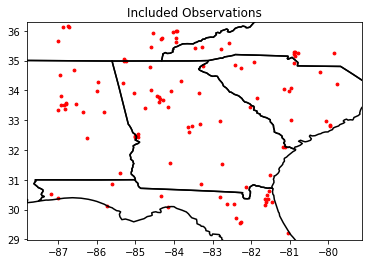

In [4]:
selected_states = ["Alabama", "Georgia", "Tennessee", "Florida", "North Carolina", "South Carolina"]
fig, axs = plt.subplots()
# SE
for selected_state in selected_states:
    state = StatePolygon(selected_state)
    if state.geom_type == "MultiPolygon":
        for geom in state.geoms:
            xs, ys = geom.exterior.xy
            axs.plot(xs, ys, 'k')
    else:
        xs, ys = state.exterior.xy
        axs.plot(xs, ys, 'k')
plt.scatter(combined_obs_dict["Lon"], combined_obs_dict["Lat"], color='red', s=8)
plt.xlim(geo["Lon_bdry"])
plt.ylim(geo["Lat_bdry"])
plt.title("Included Observations")
plt.show()

### Each year's observations

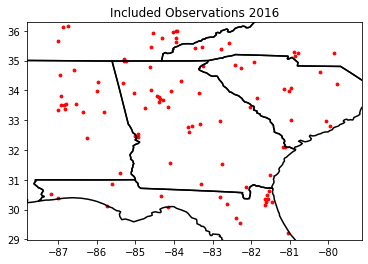

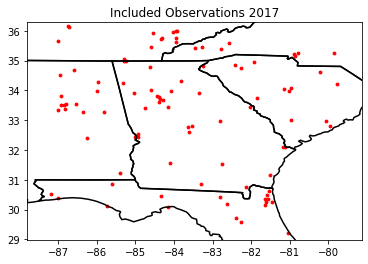

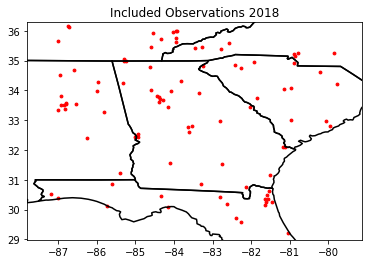

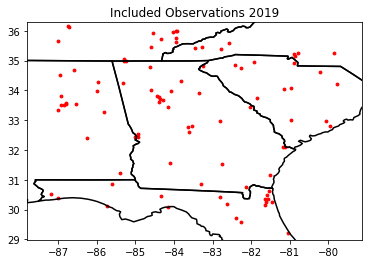

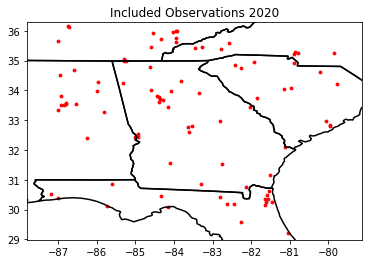

In [5]:
included_obs_years = list(yearly_obs_dict.keys())
included_obs_years.sort()
for obs_year in included_obs_years:
    fig, axs = plt.subplots()
    for selected_state in selected_states:
        state = StatePolygon(selected_state)
        if state.geom_type == "MultiPolygon":
            for geom in state.geoms:
                xs, ys = geom.exterior.xy
                axs.plot(xs, ys, 'k')
        else:
            xs, ys = state.exterior.xy
            axs.plot(xs, ys, 'k')
    plt.scatter(yearly_obs_dict[obs_year]["Lon"], yearly_obs_dict[obs_year]["Lat"], color='red', s=8)
    plt.xlim(geo["Lon_bdry"])
    plt.ylim(geo["Lat_bdry"])
    plt.title("Included Observations " + str(obs_year))
    plt.show()

# Data Fusion 1 ($FC_1$):
$$FC_1(s, t) = (\frac{OBS_m(t)}{\overline{OBS_m}})_{krig} \times \overline{FC(s)}$$
$OBS_m(t)$: observations at monitor $m$, time $t$. <br>
$\overline{OBS_m}$: annual mean observations at monitor $m$. <br>
$\overline{FC(s)}$: adjusted CMAQ results. <br>
To adjust the annual bias for CMAQ, we do the regression of annual mean measurements $\overline{OBS_m}$ and CMAQ simulations at monitor locations:
$$\overline{FC(s)} = \alpha_{year} \times \overline{CMAQ(s)}^\beta$$
$\beta$: parameters derived by doing the regression included all years data. <br>
$\alpha$: parameters derived by doing the regression for each year with $\beta$ caluclated by all years data.

In [6]:
# Generate Alpha and Beta
processed_years = list(yearly_CMAQ_dict.keys())
processed_years.sort()
for obs_year in yearly_obs_dict.keys():
    if obs_year not in processed_years:
        sys.exit("Missing observation data for " + str(obs_year) + ", please add.")

obs_yearly_mean_all = []
CMAQ_at_obs_yearly_mean_all = []
CMAQ_at_obs_yearly_mean = {}
CMAQ_at_obs_spatial_mean = {}
obs_mean_yearly = {}
obs_mean_spatial = {}
alpha_yearly = {}
for select_year in processed_years:
    current_obs_dict = yearly_obs_dict[select_year]
    current_CMAQ_dict = yearly_CMAQ_dict[select_year]
    current_CMAQ_at_obs_conc = CMAQatOBSDaily(current_obs_dict, geo, current_CMAQ_dict)
    # Temporal mean values
    current_obs_yearly_mean = np.nanmean(current_obs_dict["Conc"], axis=0)
    current_CMAQ_at_obs_yearly_mean = np.nanmean(current_CMAQ_at_obs_conc, axis=0)
    CMAQ_at_obs_yearly_mean[select_year] = current_CMAQ_at_obs_yearly_mean
    obs_mean_yearly[select_year] = current_obs_yearly_mean
    # Spatial mean values
    current_CMAQ_at_obs_spatial_mean = np.nanmean(current_CMAQ_at_obs_conc, axis=1)
    current_obs_spatial_mean = np.nanmean(current_obs_dict["Conc"], axis=1)
    CMAQ_at_obs_spatial_mean[select_year] = current_CMAQ_at_obs_spatial_mean
    obs_mean_spatial[select_year] = current_obs_spatial_mean

    obs_yearly_mean_all.append(current_obs_yearly_mean)
    CMAQ_at_obs_yearly_mean_all.append(current_CMAQ_at_obs_yearly_mean)

obs_yearly_mean_all = np.concatenate(obs_yearly_mean_all)
CMAQ_at_obs_yearly_mean_all = np.concatenate(CMAQ_at_obs_yearly_mean_all)

## Nonlinear Adjustment ($\beta \neq 1$)

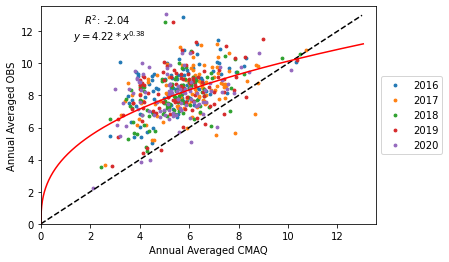

In [7]:
fig, ax = plt.subplots()
alpha_nonlinear, beta_nonlinear, score_nonlinear = adjustParameters(CMAQ_at_obs_yearly_mean_all,
                                                                    obs_yearly_mean_all)
max_value = np.max([np.max(obs_yearly_mean_all), np.max(CMAQ_at_obs_yearly_mean_all)])
for select_year in processed_years:
    plt.scatter(CMAQ_at_obs_yearly_mean[select_year], obs_mean_yearly[select_year], s=8, label=str(select_year))
plt.plot(np.arange(0, max_value, 1), np.arange(0, max_value, 1), 'k--')
plt.plot(np.arange(0, max_value, 0.01),
         alpha_nonlinear * (np.arange(0, np.max(max_value), 0.01) ** beta_nonlinear), 'r')
plt.xlim(0, max_value + 0.5)
plt.ylim(0, max_value + 0.5)
staticStr = '$R^2$: %.2f \n $y = %.2f * x^{%.2f}$' %(score_nonlinear, alpha_nonlinear, beta_nonlinear)
plt.text(0.2, 0.9, staticStr, ha='center', va='center', transform=ax.transAxes)
plt.xlabel("Annual Averaged CMAQ")
plt.ylabel("Annual Averaged OBS")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Linear Adjustment ($\beta = 1$)

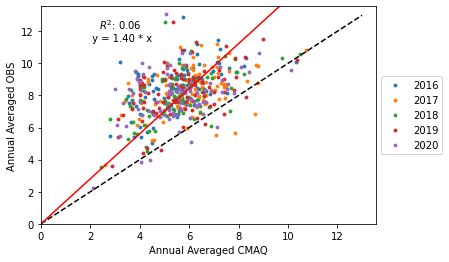

In [8]:
alpha_linear, beta_linear, score_linear = adjustParamentersLinear(CMAQ_at_obs_yearly_mean_all, obs_yearly_mean_all)
for select_year in processed_years:
    plt.scatter(CMAQ_at_obs_yearly_mean[select_year], obs_mean_yearly[select_year], s=8, label=str(select_year))
plt.plot(np.arange(0, max_value, 1), np.arange(0, max_value, 1), 'k--')
plt.plot(np.arange(0, max_value, 0.01), alpha_linear * np.arange(0, np.max(max_value), 0.01), 'r')
plt.xlim(0, max_value + 0.5)
plt.ylim(0, max_value + 0.5)
staticStr = '$R^2$: %.2f \n y = %.2f * x' %(score_linear, alpha_linear)
plt.text(0.2, 0.9, staticStr, ha='center', va='center', transform=ax.transAxes)
plt.xlabel("Annual Averaged CMAQ")
plt.ylabel("Annual Averaged OBS")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Select regression method ($\beta = 1$ or $\beta \neq 1$)

In [9]:
method = 'linear'

In [10]:
# calculate alpha and beta based on method
if method == 'linear':
    alpha = alpha_linear
    beta = beta_linear
elif method == 'nonlinear':
    alpha = alpha_nonlinear
    beta = beta_nonlinear
else:
    if score_linear >= score_nonlinear:
        print("Select linear adjustment for CMAQ, R2 score is: " + str(score_linear))
        alpha = alpha_linear
        beta = beta_linear
    else:
        print("Select nonlinear adjustment for CMAQ, R2 score is: " + str(score_nonlinear))
        alpha = alpha_nonlinear
        beta = beta_nonlinear

for select_year in processed_years:
    current_alpha = adjustParamentersYearly(beta, CMAQ_at_obs_yearly_mean[select_year],
                                            obs_mean_yearly[select_year])
    alpha_yearly[select_year] = current_alpha
    print("alpha " + str(select_year) + " :" + str(current_alpha))

print("alpha: " + str(alpha))
print("beta: " + str(beta))

alpha 2016 :1.487300378184823
alpha 2017 :1.3274807143460658
alpha 2018 :1.4011222470327984
alpha 2019 :1.421753710753338
alpha 2020 :1.3928542093999547
alpha: 1.4036996347515485
beta: 1.0


# Data Fusion 2 ($FC_2$)
$$FC_2(s, t) = CMAQ(s, t) \times \frac{\overline{FC(s)}}{\overline{CMAQ(s)}} \times \beta_{season}(t)$$
$\overline{FC(s)}$: the annual adjusted CMAQ (spatial magnitude) <br>
$CMAQ$: the annual CMAQ (spatial magnitude) <br>
For doing the temporal correction, we firstly calculate the $CMAQ(s, t) \times \frac{\overline{FC(s)}}{\overline{CMAQ(s)}}$ which denotes the magnitude adjusted CMAQ results. <br>
$$CMAQ_{adj} = CMAQ(s, t) \times \frac{\overline{FC(s)}}{\overline{CMAQ(s)}}$$
Then, we calculate the daily mean value $\overline{CMAQ_{adj, m}}$ with $\overline{OBS_{m}}$ for all monitors:
$$\overline{CMAQ_{adj, m}} = \sum_{i=1}^nCMAQ_{adj, i}$$
$$\overline{OBS_{m}}= \sum_{i=1}^nOBS_{m}$$
We do the following non-linear regression for temporal correction:
$$\frac{\overline{OBS_{m}}}{\overline{CMAQ_{adj, m}}} = \beta_{season} = e^{A \times cos[\frac{2\pi}{365.25}(t - t_{max})]}$$

In [11]:
all_obs_time_series = []
all_obs_adjusted_CMAQ_ratio = []
# Calculate A and t_max
for year in processed_years:
    current_alpha = alpha_yearly[year]
    yearly_obs = yearly_obs_dict[year]
    # Calculate A and t_max
    current_obs_time = yearly_obs["dateSeries"]
    current_CMAQ_at_obs_spatial_mean = CMAQ_at_obs_spatial_mean[year]
    current_obs_spatial_mean = obs_mean_spatial[year]
    current_adjusted_CMAQ_at_obs_spatial_mean = FC(current_CMAQ_at_obs_spatial_mean, current_alpha, beta)
    # TODO: Should be obs/CMAQ
    current_obs_adjusted_CMAQ_ratio = current_obs_spatial_mean/current_adjusted_CMAQ_at_obs_spatial_mean
    all_obs_time_series.extend(current_obs_time)
    all_obs_adjusted_CMAQ_ratio.append(current_obs_adjusted_CMAQ_ratio)
all_obs_adjusted_CMAQ_ratio = np.concatenate(all_obs_adjusted_CMAQ_ratio, axis=0)
A, t_max = temporalCorrection(all_obs_adjusted_CMAQ_ratio, all_obs_time_series)
print(" A:" + str(A) + " , t_max: " + str(t_max))

 A:0.4017100769376205 , t_max: 170.38234332114277


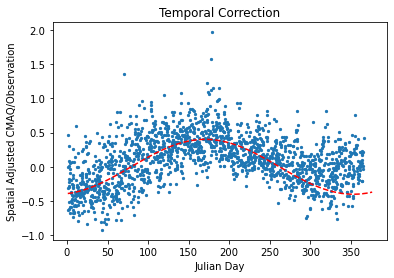

In [13]:
time_series = time_series_generator(all_obs_time_series)
log_all_obs_adjusted_CMAQ_ratio = np.log(all_obs_adjusted_CMAQ_ratio)
plt.scatter(time_series, log_all_obs_adjusted_CMAQ_ratio, s=5)
plt.plot(np.arange(1, 377, 1), A * np.cos(((2 * np.pi)/365.25) * (np.arange(1, 377, 1) - t_max)), 'r--')
plt.title("Temporal Correction")
plt.ylabel("Spatial Adjusted CMAQ/Observation")
plt.xlabel("Julian Day")
plt.show()

# Optimized Fused Fields ($FC_{opt}$)

## Calculate $R_1$
$$R_{obs}(d) = R_{coll}e^{-\frac{d}{r}}$$
$R_{obs}(d)$: the temporal Pearson correlation between pairs of monitors which are $d$ km apart. <br>
We do the regression for Pearson correlation $R_{obs}(d)$ and distance $d$ between pairs of monitors for $R_{coll}$ and $r$. <br>
The parameters is used to estimate the prediction of temporal variance by the interpolated observation data fusion method:
$$R_{1}(s, t) \approx R_{coll}e^{-\frac{x(s, t)}{r}}$$
$x(s, t)$: the distance to the nearest observation. <br>
$R_{1}(s, t)$: the estimated temporal correlation of $FC_1$ and ambient pollution.

In [14]:
[corrCoef, distance] = ROBSData(combined_obs_dict["Conc"], combined_obs_dict["X"], combined_obs_dict["Y"])
[r, Rcoll] = ROBS(corrCoef, distance)
print("r: " + str(r))
print("Rcoll: " + str(Rcoll))

r: 497.4842703719147
Rcoll: 0.8825200262512555


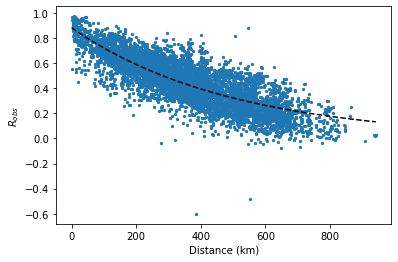

In [15]:
max_dist_value = np.max(distance)
fig, ax = plt.subplots()
plt.scatter(distance, corrCoef, s=5)
plt.plot(np.arange(0, max_dist_value, 1), Rcoll * np.exp(-np.arange(0, max_dist_value, 1)/r), 'k--')
predict_corr = Rcoll * np.exp(distance/r)
model_r2_score = r2_score(predict_corr, corrCoef)
plt.xlabel("Distance (km)")
plt.ylabel("$R_{obs}$")
plt.show()

## Calculate $R_2$
$$R_{CMAQ} = \frac{1}{N}\sum_{m=1}^N corr(OBS_m(t), CMAQ_m(t)) \approx R_2$$
$R_{CMAQ}$: mean pearsin correlations between observation and CMAQ values at observations. <br>
$OBS_m(t)$: observation values at monitor $m$.<br>
$CMAQ_m(t)$: CMAQ values at monitor $m$.

In [16]:
CMAQ_at_obs_combined = CMAQatOBSDaily(combined_obs_dict, geo, combined_CMAQ_dict)
R2 = RCMAQ(combined_obs_dict["Conc"], CMAQ_at_obs_combined)
print("R2: " + str(R2))

R2: 0.41312487439851325


### Correlations for each sites

In [17]:
siteSize = combined_obs_dict["Conc"].shape[1]
valid_site_idx = []
corrCoef = []
for i in range(0, siteSize):
    CMAQConcTmp = CMAQ_at_obs_combined[:, i]
    OBSConcTmp = combined_obs_dict["Conc"][:, i]
    valid_idx = (~np.isnan(CMAQConcTmp)) & (~np.isnan(OBSConcTmp))
    # Delete the nan number
    CMAQConcTmp = CMAQConcTmp[valid_idx]
    OBSConcTmp = OBSConcTmp[valid_idx]
    if len(CMAQConcTmp) <= 1 or len(OBSConcTmp) <= 1:
        continue
    valid_site_idx.append(i)
    pearson_r = scipy.stats.pearsonr(CMAQConcTmp, OBSConcTmp)
    corrCoef.append(pearson_r[0])
site_lat = combined_obs_dict["Lat"][valid_site_idx]
site_lon = combined_obs_dict["Lon"][valid_site_idx]

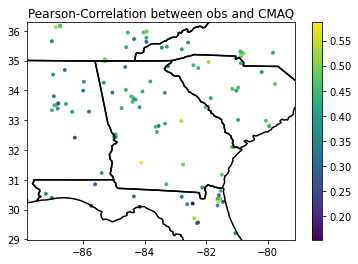

In [18]:
fig, axs = plt.subplots()
# SE
for selected_state in selected_states:
    state = StatePolygon(selected_state)
    if state.geom_type == "MultiPolygon":
        for geom in state.geoms:
            xs, ys = geom.exterior.xy
            axs.plot(xs, ys, 'k')
    else:
        xs, ys = state.exterior.xy
        axs.plot(xs, ys, 'k')
plt.scatter(site_lon, site_lat, c=corrCoef, s=8)
plt.xlim(geo["Lon_bdry"])
plt.ylim(geo["Lat_bdry"])
plt.colorbar()
plt.title("Pearson-Correlation between obs and CMAQ")
plt.show()

## Calculating Weight Factors
To combine $FC_1$ and $FC_2$, we calculate a weight factors based on $R_1$ and $R_2$.
$$W(s, t) = \frac{R_1(s, t) \times (1 - R_2)}{R_1(s, t) \times (1 - R_2) + R_2 \times (1 - R_1(s, t))}$$
Then, we use $W$ to calculate $FC_{opt}$
$$FC_{opt}(s, t) = W(s, t) \times FC_1(s, t) + (1 - W(s, t)) \times FC_2(s, t)$$
Here, we visualize the weight factors spatial distribution for all years:

In [19]:
W_all_year = []
for year in processed_years:
    current_alpha = alpha_yearly[year]
    yearly_obs = yearly_obs_dict[year]
    yearly_CMAQ = yearly_CMAQ_dict[year]
    R_1 = R1(yearly_obs, geo, Rcoll, r)
    W = weightFactor(R_1, R2)
    W_all_year.append(W)
W_all_year = np.concatenate(W_all_year, axis=0)

/var/folders/yp/3kbl64m10ml4713p_fzq0znc0000gn/T/ipykernel_92968/1374929697.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(geo["Lon"], geo["Lat"], W_all_year_mean)


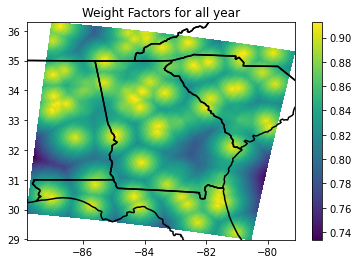

In [20]:
W_all_year_mean = np.mean(W_all_year, axis=0)
fig, axs = plt.subplots()
# SE
for selected_state in selected_states:
    state = StatePolygon(selected_state)
    if state.geom_type == "MultiPolygon":
        for geom in state.geoms:
            xs, ys = geom.exterior.xy
            axs.plot(xs, ys, 'k')
    else:
        xs, ys = state.exterior.xy
        axs.plot(xs, ys, 'k')
plt.pcolor(geo["Lon"], geo["Lat"], W_all_year_mean)
plt.xlim(geo["Lon_bdry"])
plt.ylim(geo["Lat_bdry"])
plt.colorbar()
plt.title("Weight Factors for all year")
plt.show()